<a href="https://colab.research.google.com/github/AnuragAgrahari04/Air_Canvas/blob/main/QKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip uninstall qiskit qiskit_machine_learning qiskit_aer
!pip install qiskit==0.43.3 qiskit_machine_learning==0.6.1 qiskit_aer==0.12.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.2 MB/s eta 0:00:00
  Created wheel for qiskit: fil

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
from qiskit import Aer
warnings.filterwarnings("ignore")

In [ ]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Qiskit imports
from qiskit import Aer, QuantumCircuit, execute
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Shrink to avoid timeout
X_train = X_train.iloc[:100]
y_train = y_train.iloc[:100]
X_test = X_test.iloc[:5]
y_test = y_test.iloc[:5]

In [ ]:
# ============================ #
#        Configurable Params   #
# ============================ #
NUM_FEATURES = 15  # Set -1 to use all available features as qubits
TRAIN_SIZE = 7000  # Set -1 to use all available samples
CIRCUIT_REPS = 2     # Depth of feature map
TEST_RATIO = 0.25

#case 1: full samples and full features
#case 2: 10000 samples and full features
#case 3: full samples and reduce features
#case 4: 10000 samples and reduces features
#case 5: reduces samples and features to fit the harware specs

In [ ]:
# ============================ #
#         Load Dataset         # enter train and test dataset generated in the previous script here.
# ============================ #
print("Loading angle-encoded training and testing datasets...")
train_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_train.xlsx')
test_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_test.xlsx')

full_df = pd.concat([train_df, test_df], ignore_index=True)
X_full = full_df.drop(columns=['Label'])
y_full = full_df['Label']

print(f"Total Samples: {len(X_full)}, Total Classes: {len(np.unique(y_full))}")

Loading angle-encoded training and testing datasets...
Total Samples: 100000, Total Classes: 2


In [ ]:
NUM_FEATURES = 15
TRAIN_SIZE = 7000
TEST_RATIO = 0.25

selected_features = X_full.columns[:NUM_FEATURES].tolist()

X_full = X_full[selected_features]

# Stratified split
sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, test_size=int(TEST_RATIO*TRAIN_SIZE), random_state=42)
for train_idx, test_idx in sss.split(X_full, y_full):
    X_train, X_test = X_full.iloc[train_idx], X_full.iloc[test_idx]
    y_train, y_test = y_full.iloc[train_idx], y_full.iloc[test_idx]

print(f"Using {len(selected_features)} features (qubits).")

Using 15 features (qubits).


In [ ]:
def build_qknn_circuit(x1, x2):
    num_qubits = len(x1)
    qc = QuantumCircuit(num_qubits)

    # Encode x1 and inverse of x2
    for i in range(num_qubits):
        qc.ry(x1[i], i)
    for i in range(num_qubits):
        qc.ry(-x2[i], i)

    qc.measure_all()
    return qc

In [ ]:
def fidelity_distance(circuit):
    backend = Aer.get_backend("qasm_simulator")
    result = execute(circuit, backend=backend, shots=1024).result()
    counts = result.get_counts()

    zero_state = '0' * circuit.num_qubits
    fidelity = counts.get(zero_state, 0) / 1024
    return 1 - fidelity

In [ ]:
def qknn_predict(X_train, y_train, X_test, k=3):
    predictions = []

    for idx, test_point in enumerate(X_test.values):
        distances = []

        for i, train_point in enumerate(X_train.values):
            qc = build_qknn_circuit(test_point, train_point)
            dist = fidelity_distance(qc)
            distances.append((dist, y_train.iloc[i]))

        distances.sort(key=lambda x: x[0])
        top_k = [label for _, label in distances[:k]]
        prediction = Counter(top_k).most_common(1)[0][0]
        predictions.append(prediction)

    return predictions

In [ ]:
y_pred = qknn_predict(X_train, y_train, X_test, k=3)

acc = accuracy_score(y_test, y_pred)
print(f"\nQKNN Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


QKNN Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🔍 QKNN Accuracy: {accuracy * 100:.2f}%\n")

# Full classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))


🔍 QKNN Accuracy: 100.00%

📊 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



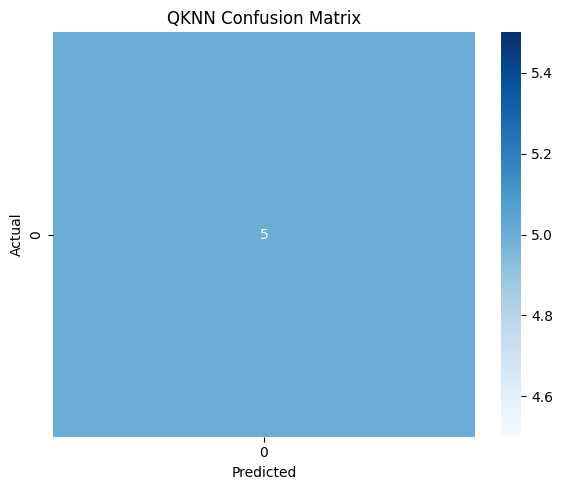

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("QKNN Confusion Matrix")
plt.tight_layout()
plt.show()

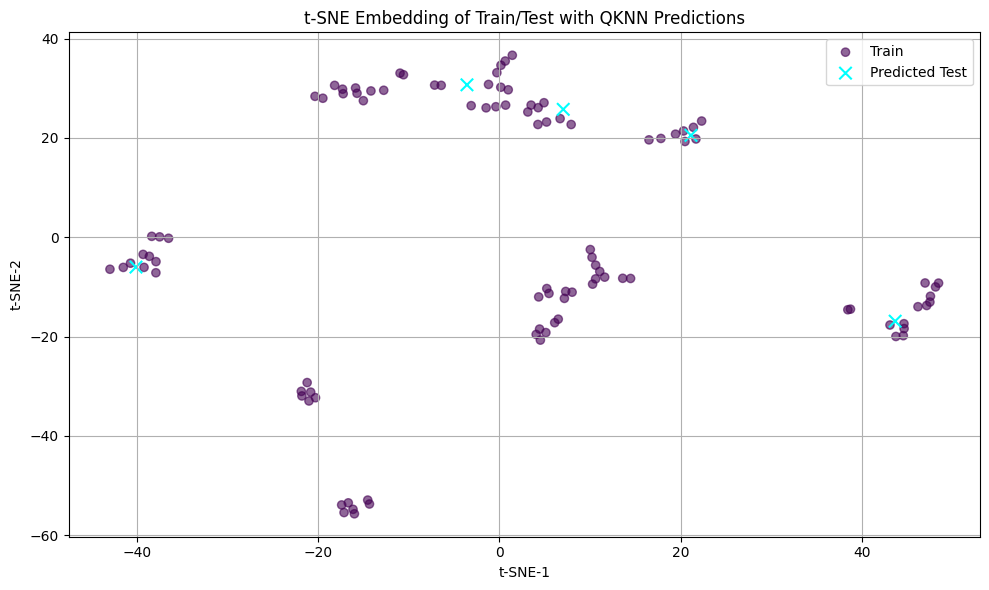

In [ ]:
from sklearn.manifold import TSNE

# Combine and reduce dimensions
X_all = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_embedded = tsne.fit_transform(X_all)

# Split again
X_train_emb = X_embedded[:len(X_train)]
X_test_emb = X_embedded[len(X_train):]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train_emb[:, 0], X_train_emb[:, 1], c=y_train, cmap='viridis', label='Train', marker='o', alpha=0.6)
plt.scatter(X_test_emb[:, 0], X_test_emb[:, 1], c=y_pred, cmap='cool', label='Predicted Test', marker='x', s=80)
plt.legend()
plt.title("t-SNE Embedding of Train/Test with QKNN Predictions")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.tight_layout()
plt.show()